In [1]:
library(tidyverse)
library(cowplot)
library(mgcv)
library(broom)

options(readr.show_col_types = FALSE)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘cowplot’ was built under R version 4.3.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-p

In [2]:
full_df <- read_tsv("data/full_summary.tsv") %>%
    mutate(
        i = str_extract(path, "(?<=sim_)[0-9]+"),
        h = str_extract(path, "(?<=h_)[\\.0-9]+"),
        s = str_extract(path, "(?<=s_)[\\.0-9]+"),
        p = str_extract(path, "(?<=p_)[\\.0-9]+"),
        across(c(i, h, s, p), as.double),
    ) %>%
    distinct %>%
    mutate(
        missingness = if_else(
            str_detect(method, "m_[0-9]+"), 
            str_extract(method, "(?<=m_)([0-9\\.]+)") %>% as.double, 
            0
        ),
        variance = if_else(
            str_detect(method, "v_[0-9]+"),
            str_extract(method, "(?<=v_)([0-9\\.]+)") %>% as.double,
            0
        ),
    )

full_df %>% dim

full_df %>% head(2)

[1] 1560000      21

phenotype,method,P,N,TP,TN,FP,FN,total,bias,⋯,AUROC,sensitivity,specificity,path,i,h,s,p,missingness,variance
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Trait_14,liability,593,1491,106,1423,68,487,2084,0.0007791386,⋯,0.6070006,0.1787521,0.9543930,data/simulations/sim_29_h_0.1_s_0.5_p_0.7/summary/liability.tsv,29,0.1,0.5,0.7,0,0
Trait_44,liability,992,1516,410,1456,60,582,2508,-0.0004492340,⋯,0.8207919,0.4133065,0.9604222,data/simulations/sim_29_h_0.1_s_0.5_p_0.7/summary/liability.tsv,29,0.1,0.5,0.7,0,0


# Main plot

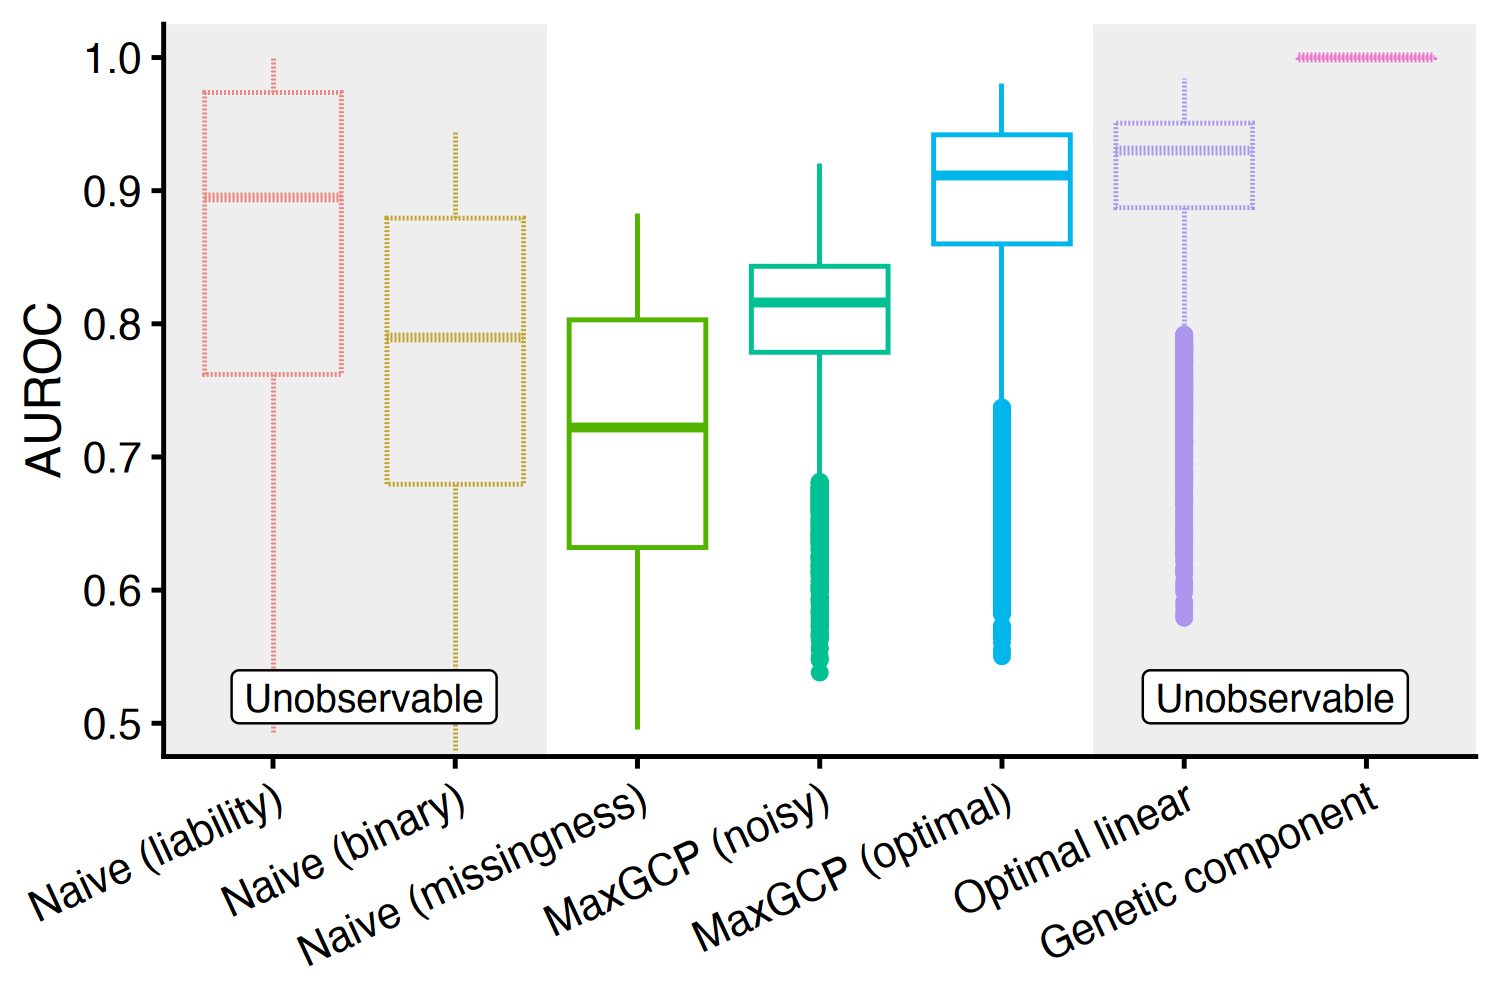

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 250)

auroc_plot <- full_df %>%
    mutate(
        method = method %>%
            recode_factor(
                liability = "Naive (liability)",
                `binary_m_0.0` = "Naive (binary)",
                `binary_m_0.25` = "Naive (missingness)",
                `maxgcp_m_0.25_v_0.05` = "MaxGCP (noisy)",
                `maxgcp_m_0.25_v_0.0` = "MaxGCP (optimal)",
                optimal = "Optimal linear",
                g = "Genetic component",
            ),
        dashed = method %in% c("Naive (liability)", "Naive (binary)", "Optimal linear", "Genetic component")
    ) %>%
    filter(!str_detect(method, "_")) %>%
    filter(h == 0.5, s == 0.9, p == 0.0) %>%
    distinct %>%
    ggplot(aes(x = method, y = AUROC, color = method)) +
    geom_boxplot(aes(linetype = dashed)) +
    annotate(
        geom = "rect", xmin = -Inf, xmax = 2.5, ymin = -Inf, ymax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(
        geom = "rect", xmin = 5.5, xmax = Inf, ymin = -Inf, ymax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(geom = "label", x = 1.5, y = 0.5, label = "Unobservable", hjust = 0.5, vjust = 0) +
    annotate(geom = "label", x = 6.5, y = 0.5, label = "Unobservable", hjust = 0.5, vjust = 0) +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle = 25, hjust = 1),
        axis.title.x = element_blank(),
        legend.position = "none"
    ) +
    coord_cartesian(ylim = c(0.5, 1))

save_plot("img/main.auroc.png", auroc_plot, base_width = 6, base_height = 4, dpi = 400)

auroc_plot

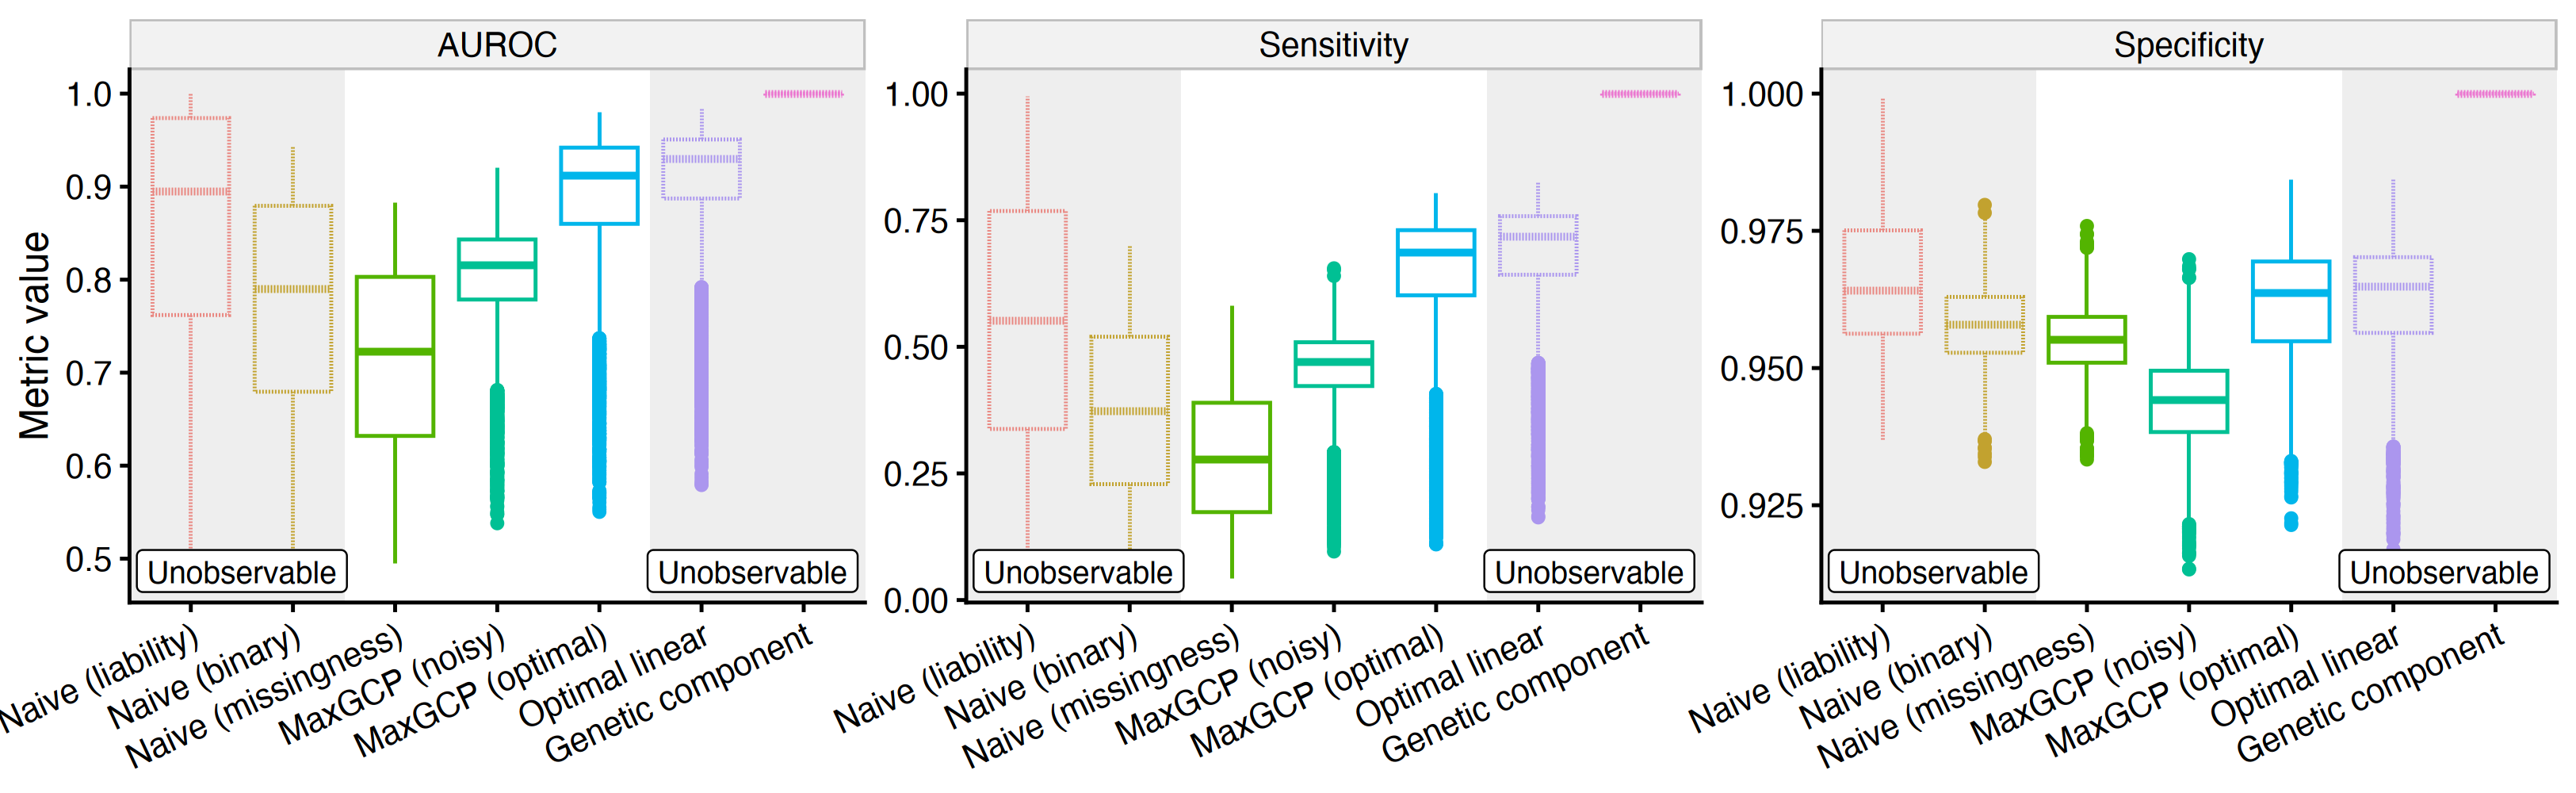

In [4]:
options(repr.plot.width = 13, repr.plot.height = 4, repr.plot.res = 250)

main_plot <- full_df %>%
    mutate(
        method = method %>%
            recode_factor(
                liability = "Naive (liability)",
                `binary_m_0.0` = "Naive (binary)",
                `binary_m_0.25` = "Naive (missingness)",
                `maxgcp_m_0.25_v_0.05` = "MaxGCP (noisy)",
                `maxgcp_m_0.25_v_0.0` = "MaxGCP (optimal)",
                optimal = "Optimal linear",
                g = "Genetic component",
            ),
        dashed = method %in% c("Naive (liability)", "Naive (binary)", "Optimal linear", "Genetic component"),
    ) %>%
    filter(!str_detect(method, "_")) %>%
    filter(h == 0.5, s == 0.9, p == 0.0) %>%
    distinct %>%
    rename(Sensitivity = sensitivity, Specificity = specificity) %>%
    pivot_longer(c(AUROC:Specificity), names_to = "metric", values_to = "metric_value") %>%
    ggplot(aes(x = method, y = metric_value, color = method)) +
    geom_boxplot(aes(linetype = dashed)) +
    annotate(
        geom = "rect", xmin = -Inf, xmax = 2.5, ymin = -Inf, ymax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(
        geom = "rect", xmin = 5.5, xmax = Inf, ymin = -Inf, ymax = Inf,
        fill = "grey", color = "transparent", alpha = 0.25,
    ) +
    annotate(geom = "label", x = 1.5, y = -Inf, label = "Unobservable", hjust = 0.5, vjust = -0.25) +
    annotate(geom = "label", x = 6.5, y = -Inf, label = "Unobservable", hjust = 0.5, vjust = -0.25) +
    theme_cowplot() +
    facet_wrap(vars(metric), scales = "free_y") +
    theme(
        axis.text.x = element_text(angle = 25, hjust = 1),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.background = element_rect(fill = "grey95", color = "grey75")
    ) +
    ylab("Metric value")

save_plot("img/main.all.png", main_plot, base_width = 13, base_height = 4, dpi = 400)

main_plot

# Simulation parameters plot

In [5]:
merged_df <- bind_rows(
    # Across heritability
    full_df %>%
        filter(s == 0.5, p == 0.0) %>%
        mutate(plot = "h2") %>%
        select(plot, method, x = h, AUROC, sensitivity, specificity),
    # Across genetic correlation
    full_df %>%
        filter(h == 0.1, p == 0.0, s > 0) %>%
        mutate(plot = "rg") %>%
        select(plot, method, x = s, AUROC, sensitivity, specificity),
    # Across missingness
    full_df %>%
        filter(h == 0.1, s == 0.5, p == 0) %>%
        mutate(
            plot = "missingness",
            method = method %>%
                str_replace(pattern = "_m_[0-9\\.]+", replacement = "") %>%
                recode(
                    liability = "Naive (liability)",
                    `binary` = "Naive (missingness)",
                    `maxgcp_v_0.05` = "MaxGCP (noisy)",
                    `maxgcp_v_0.0` = "MaxGCP (optimal)",
                    optimal = "Optimal linear",
                    g = "Genetic component",
                ),
        ) %>%
        select(plot, method, x = missingness, AUROC, sensitivity, specificity),
    # Across variance in genetic covariance estimates
    full_df %>%
        filter(h == 0.1, s == 0.5, p == 0) %>%
        mutate(
            plot = "variance",
            method = method %>%
                str_replace(pattern = "_v_[0-9\\.]+", replacement = "") %>%
                recode(
                    liability = "Naive (liability)",
                    `binary_m_0.0` = "Naive (binary)",
                    `binary_m_0.25` = "Naive (missingness)",
                    `maxgcp_m_0.25` = "MaxGCP (noisy)",
                    optimal = "Optimal linear",
                    g = "Genetic component",
                ),
        ) %>%
        select(plot, method, x = variance, AUROC, sensitivity, specificity),
) %>%
    mutate(
        method = method %>%
            recode(
                liability = "Naive (liability)",
                `binary_m_0.0` = "Naive (binary)",
                `binary_m_0.25` = "Naive (missingness)",
                `maxgcp_m_0.25_v_0.05` = "MaxGCP (noisy)",
                `maxgcp_m_0.25_v_0.0` = "MaxGCP (optimal)",
                optimal = "Optimal linear",
                g = "Genetic component",
            ) %>%
            factor(levels = c(
                "Genetic component", "Optimal linear", "Naive (liability)", "Naive (binary)", "Naive (missingness)",
                "MaxGCP (noisy)", "MaxGCP (optimal)"
            )),
        dashed = if_else(
                method %in% c("Naive (liability)", "Naive (binary)", "Optimal linear", "Genetic component"),
                "Unobservable", "Observable"),
        plot = recode_factor(
            plot, h2 = "Heritability", rg = "Genetic correlation", missingness = "Missingness", variance = "Variance"
        )
    ) %>%
    filter(!str_detect(method, "_")) 

In [6]:
plot_df <- merged_df %>%
    pivot_longer(AUROC:specificity, names_to = "metric", values_to = "y") %>%
    nest(data = c(x, y)) %>%
    rowwise() %>%
    filter(pmin(nrow(distinct(data, x)), nrow(distinct(data, x))) >= 10) %>%
    mutate(
        model = gam(y ~ s(x, k = 10), data = data) %>% 
            augment(newdata = data.frame(x = seq(0, 1, length.out = 100))) %>% 
            list
    ) %>%
    ungroup %>%
    select(-data) %>%
    unnest(model)

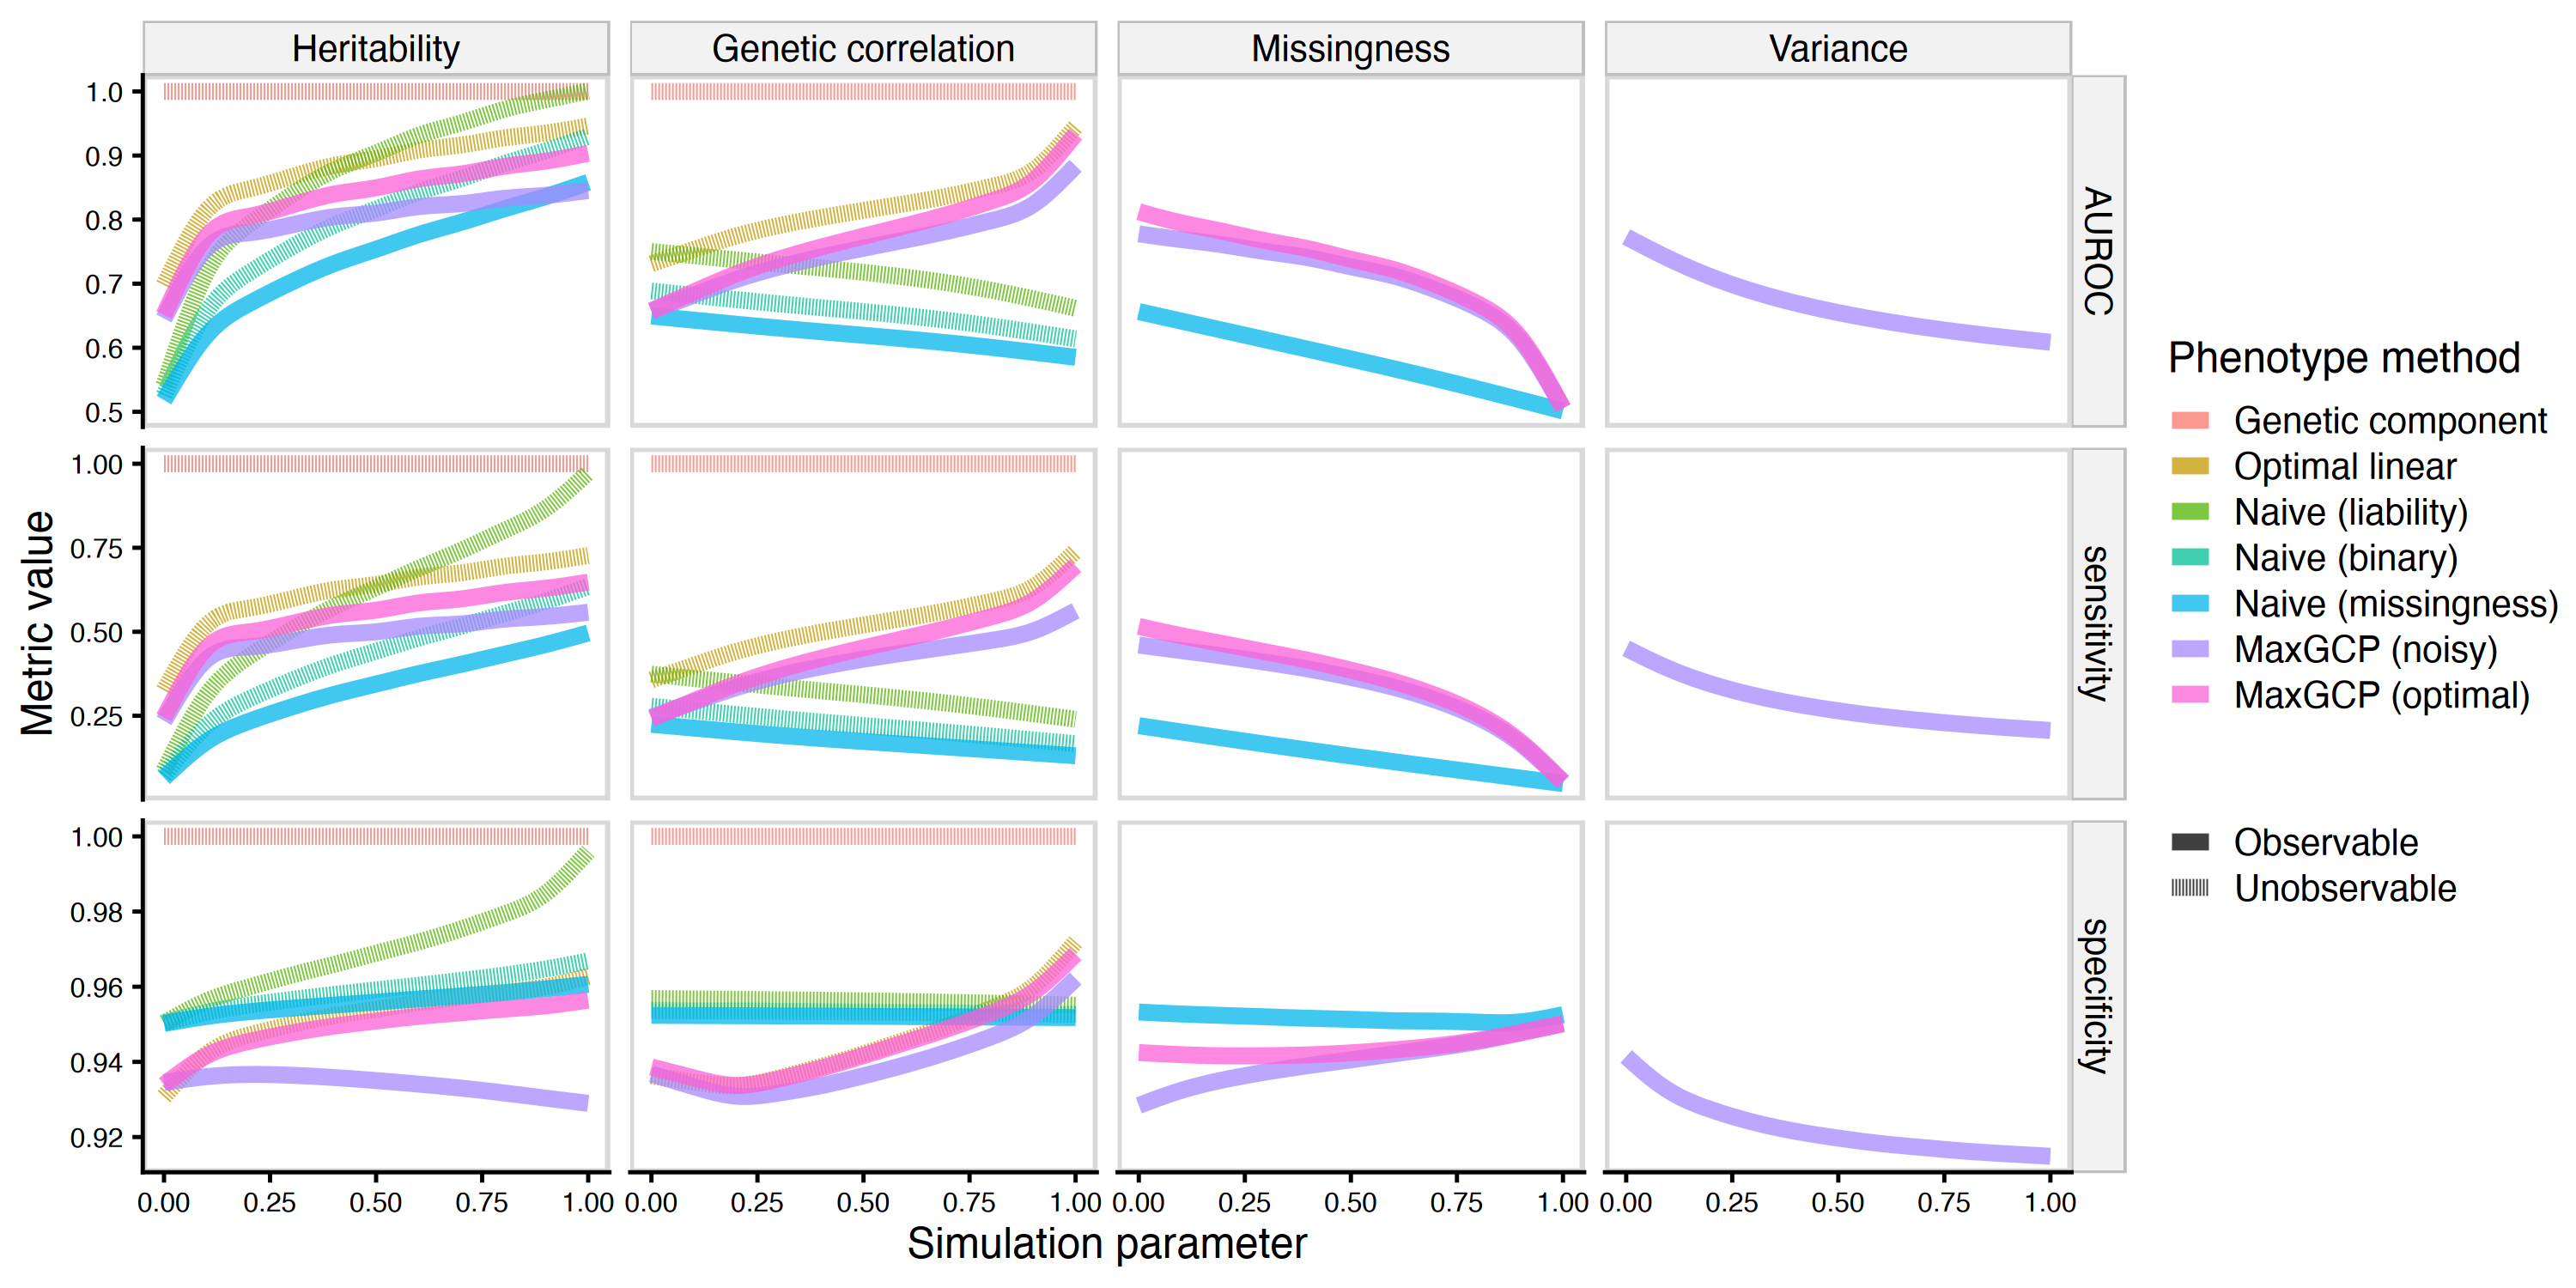

In [7]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 250)

parameters_plot <- plot_df %>%
    ggplot(aes(x = x, y = .fitted, group = method, color = method, linetype = dashed)) +
    geom_line(linewidth = 2, alpha = 0.75) +
    facet_grid(rows = vars(metric), cols = vars(plot), scales = "free_y") +
    scale_linetype_discrete(name = "") +
    scale_color_discrete(name = "Phenotype method") +
    theme_cowplot() +
    panel_border() +
    theme(
        axis.text = element_text(size = 9),
        strip.background = element_rect(fill = "grey95", color = "grey75")
    ) +
    xlab("Simulation parameter") +
    ylab("Metric value")

save_plot("img/parameters.png", parameters_plot, base_width = 12, base_height = 6, dpi = 400)

parameters_plot